# 3 Overlap in Lexical and Literary Vocabulary

This notebook compares the vocabulary of Old Babylonian lexical texts and the vocabulary of the Sumerian literary corpus as represented in the [literary](http://oracc.org/epsd2/literary) sub-project of the Electronic Pennsylvania Sumerian Dictionary ([epsd2](http://oracc.org/epsd2/literary)). 

## 3.0 The Corpora

Currently, the [literary](http://oracc.org/epsd2/literary) corpus in [epsd2](http://oracc.org/epsd2/literary) consists of the following text groups: 
- almost 400 literary compositions in composite transliteration derived from the Electronic Text Corpus of Sumerian Literature ([ETCSL](http://etcsl.orinst.ox.ac.uk/)), adjusted to [epsd2](http://oracc.org/epsd2) standards. The Gudea Cylinders, which are part of the [ETCSL](http://etcsl.orinst.ox.ac.uk/) corpus, have been removed from the [epsd2/literary](http://oracc.org/epsd2/literary) corpus, because they are available in the [epsd2/royal](http://oracc.org/epsd2/royal) project.
- the literary texts from Old Babylonian Ur published in UET 6/1-3, edited by Jeremiah Peterson and lemmatized by Niek Veldhuis and Steve Tinney.
- a somewhat random collection of literary texts scattered over recently published books and articles. This collection includes most of CUSAS 38 (by Christopher Metcalf; 2019) and various other texts.

The [ETCSL](http://etcsl.orinst.ox.ac.uk/) collection provides composite texts, the other collections include individual exemplars. There is, therefore, some duplication in [epsd2/literary](http://oracc.org/epsd2/literary). The [*Lament for Sumer and Ur*](http://etcsl.orinst.ox.ac.uk/cgi-bin/etcsl.cgi?text=t.2.2.3#), for instance, is represented by a composite text from [ETCSL](http://etcsl.orinst.ox.ac.uk/cgi-bin/etcsl.cgi?text=t.2.2.3#), but also by 14 exemplars from Ur. The exemplars yield variants but mostly duplicate the composite text. On the other hand, the exemplars from Nippur and other places (and the variants that they yield) are not currently represented in the corpus.

The lexical corpus under consideration is taken from the Digital Corpus of Cuneiform Lexical Texts ([DCCLT](http://oracc.org/dcclt)), in particular those that date to the Old Babylonian period. This corpus includes both composite texts (primarily for the Nippur material) and individual exemplars. Exemplars that belong to a composite text are, for the most part, not lemmatized and will therefore not figure in the current comparison.

## 3.1 Counting Words and Expressions

In this notebook we will simply count lemmas and expressions in lexical texts and in the Old Babylonian Sumerian literary corpus and compute the amount of overlap. The vocabularies and their intersection will be visualized in Venn diagrams.

### 3.1.0 Preparation 
The code below uses the package `matplotlib_venn`, which is currently not part of the set of packages installed with Anaconda. Run the following line in a notebook in order to install the module (see [install_packages.ipynb](../1_Preliminaries/install_packages.ipynb) for more information about installing modules): 

```python
%conda install -c conda-forge matplotlib-venn
```

Note that the package is *imported* as matplotlib_venn (with underscore) but must be *installed* as matplotlib-venn (with dash). Installation of a package can take quite some time, but it needs to be done only once. 

In [1]:
%matplotlib inline  
# %matplotlib inline enables drawing of visualizations in the Notebook
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # this suppresses a warning about pandas from tqdm
import pandas as pd
import os
import sys
from tqdm.auto import tqdm
tqdm.pandas() # initiate pandas support in tqdm, allowing progress_apply() and progress_map()
from matplotlib import pyplot as plt
from matplotlib_venn import venn2
from nltk.tokenize import MWETokenizer
import zipfile
import json
util_dir = os.path.abspath('../utils')
sys.path.append(util_dir)
from utils import *

#### 3.1.0.1 Read Lexical and Literary Data
The module `utils` in the `utils` directory of Compass includes the function `get_data()` which essentially runs the same code as the [Extended ORACC Parser](../2_1_Data_Acquisition_ORACC/2_1_3_extended_ORACC-JSON_parser.ipynb) (see there for explanation of the code). Its only parameter is a string with [ORACC](http://oracc.org) project names, separated by commas. It returns a Pandas DataFrame in which each word is represented by a row.

In [2]:
projects = "dcclt, dcclt/nineveh, dcclt/signlists, dcclt/ebla, epsd2/literary"
words = get_data(projects)

Saving http://build-oracc.museum.upenn.edu/json/dcclt-nineveh.zip as jsonzip/dcclt-nineveh.zip.



Saving http://build-oracc.museum.upenn.edu/json/dcclt-ebla.zip as jsonzip/dcclt-ebla.zip.



Saving http://build-oracc.museum.upenn.edu/json/dcclt.zip as jsonzip/dcclt.zip.



Saving http://build-oracc.museum.upenn.edu/json/epsd2-literary.zip as jsonzip/epsd2-literary.zip.



Saving http://build-oracc.museum.upenn.edu/json/dcclt-signlists.zip as jsonzip/dcclt-signlists.zip.



Parsing JSON


#### 3.1.0.2 Lemmas
First, only those rows are selected that have `sux` (Sumerian) in the language (`lang`) field. This removes not only Akkadian glosses and translations, but also entries that represent horizontal rulings, breakage, etc.

The `lemma` column is created by combining Citation Form (`cf`), Guide Word (`gw`) and Part of Speech (`pos`) with a list comprehension. A single lemma now looks like `lugal[king]N`. The list comprehension has one condition: if there is no Citation Form (column `cf` equals the empty string) the contents of the column `form` are taken, followed by `[NA]NA`. The absence of a Citation Form implies that the word was not lemmatized (perhaps an unknown or a broken word). The field `form` contains the raw transliteration - the result may be `x-ra-bi[NA]NA`.

For the current analysis we will use *lemmatized* forms for the comparison between literary and lexical vocabulary. The advantage of using lemmatized forms is that we can easily match, for instance `a naŋ` (to drink water) with `a mu-naŋ` (he drank water), because both are lemmatized as `a[water]N naŋ[drink]V/t`. The unlemmatized forms, therefore, are of little importance here. We need to keep them, for now, because we will also compare *sequences* of lemmas in lexical and literary texts. Premature removal of unlemmatized forms would result in false positives. For instance, the sequence `dumu[child]N x[NA]NA lugal[king]N` should *not* result in a match for the lemma sequence (or multiple word expression) `dumu[child]N lugal[king]N`.

Finally, all lemmas are lower cased, to avoid confusion.

In [3]:
words = words.loc[words["lang"].str.contains("sux")] 
# remove Akkadian glosses etc as well entries that note horizontal rulings, breakage, etc.

In [4]:
words["lemma"] = words.progress_apply(lambda r: f"{r['cf']}[{r['gw']}]{r['pos']}" 
                            if r["cf"] != '' else f"{r['form']}[NA]NA", axis=1)
words["lemma"] = words["lemma"].str.lower()

Sign lists (which belong to the broader category of lexical lists) list cuneiform signs with pronunciation glosses and sometimes with Akkadian translation, sign name, and other information. For the current purposes we *only* need the Sumerian word that is represented by the entry. We remove entries that derive from the pronunciation glosses and the signs themselves. Sign names and translation into Akkadian (or other languages) are already removed, because we have selected for Sumerian only in the previous cell.

The Pandas function `isin()` compares the contents of a field with a list and returns a boolean (`True` or `False`). In this case the column `field` (which is primarily used for sign lists) is compared to the list `["sg", "pr"]`. If `field` equals one of these terms `isin()` returns `True`. The `~` before the entire expression changes `True` into `False` and vv. As a result the dataframe `words` now omits all rows that have either "sg" or "pr" in the column `field`.

In [5]:
# remove lemmas that derive from the fields "sign" 
# or "pronunciation" in sign lists.
words = words[~words["field"].isin(["sg", "pr"])] 

#### 3.1.0.3 Split into Lexical and Literary

In [6]:
lex_words = words.loc[words.id_text.str.contains('dcclt')]
lit_words = words.loc[words.id_text.str.contains('epsd2/literary')]

#### 3.1.0.4 Select Old Babylonian Lexical Texts
The compositions in [epsd2/literary](http://oracc.org/epsd2/literary) are from the Old Babylonian period. We will use the [DCCLT](http://oracc.org/dcclt) catalog to select only those lexical texts that come from that same period.

The catalog is included as a separate `json` file in `dcclt.zip`. Since we parsed the [DCCLT](http://oracc.org/dcclt) text editions earlier in this script, the file `dcclt.zip` should still be in the `jsonzip` directory, we do not have to download it.

For more information about handling the file `catalogue.json` see the notebook [2_1_1_parse-json-cat.ipynb](../2_1_Data_Acquisition_ORACC/2_1_1_parse-json-cat.ipynb).

The resulting dataframe is reduced to just two columns: `id_text` and `period` so that we can select the ones that have "Old Babylonian" in the `period` column.

In [7]:
file = "jsonzip/dcclt.zip"
z = zipfile.ZipFile(file) 
st = z.read("dcclt/catalogue.json").decode("utf-8")
j = json.loads(st)
cat_df = pd.DataFrame(j["members"]).T
cat_df["id_text"] = cat_df["id_text"].fillna(cat_df["id_composite"])
cat_df = cat_df[["id_text", "period"]]

In [8]:
ob = cat_df[cat_df["period"] == "Old Babylonian"]
ob[:10]

,id_text,period
P117394,P117394,Old Babylonian
P117395,P117395,Old Babylonian
P117396,P117396,Old Babylonian
P117397,P117397,Old Babylonian
P117404,P117404,Old Babylonian
P128345,P128345,Old Babylonian
P142806,P142806,Old Babylonian
P145550,P145550,Old Babylonian
P209775,P209775,Old Babylonian
P209812,P209812,Old Babylonian


The index of the resulting dataframe `ob` is identical to the column `id_text` (the P, Q, or X number of each text). We can retrieve the index with the Pandas command `index.values`, which returns a list. These are the P/Q/X numbers that we want to keep.

In the dataframe `lex_words` all text IDs are preceded by `dcclt/`, `dcclt/signlists`, etc. We will compare the last seven characters of `id_text` (the P, Q, or X number), to see if that number appears in `keep`. This will select the Old Babylonian entries.

In [9]:
keep = ob.index.values
lex_words = lex_words.loc[lex_words["id_text"].str[-7:].isin(keep)]

### 3.1.1 First Approximation
Now we have two dataframes: `lit_words` and `lex_words`. In both the field `lemma` contains the lemmatization data of a single word. We can extract the unique lemmas with the `set()` command (a set is an unordered collection of unique elements). We remove the non-lemmatized words (those have `na` as Guide Word and `na` as POS) with a set comprehension, and compare the two resulting sets in a [Venn diagram](https://en.wikipedia.org/wiki/Venn_diagram).

In [10]:
lit_words_s = set(lit_words["lemma"])
lexical_words_s = set(lex_words["lemma"])
lit_words_s = {lemma for lemma in lit_words_s if not '[na]na' in lemma}
lexical_words_s = {lemma for lemma in lexical_words_s if not '[na]na' in lemma}

The `venn2` command from the `matplotlib_venn` library creates a Venn diagram of two sets. Each set is represented by a circle, the diameter of the circle is related to the number of elements in the set. The intersection of the circles represents elements that are contained in both sets.

In its most basic form the `venn2()` command simply takes a list that contains the two sets.

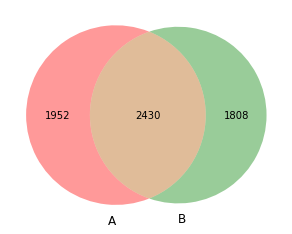

In [11]:
venn2([lit_words_s, lexical_words_s]);

This basic plot is not too informative because it does not include the size of each set, nor its name. We can customize colors, size of the plot, and the legends. This customization is put in a function so it can be reused later on.

In [12]:
def plot_venn(lit_vocab, lex_vocab, file = 'venn_plot.png'):
    """The function takes two sets as arguments and draws a Venn diagram 
    that shows the intersection between the two sets.
    The legend includes the size of each set and the size 
    of the intersection with the other set as a percentage.
    """
    plt.figure(figsize=(8,8))
    lit_abs = len(lit_vocab)
    lex_abs = len(lex_vocab)
    inter_abs = len(lit_vocab.intersection(lex_vocab))
    lit_per = "{:.0%}".format(inter_abs/lit_abs)
    lex_per = "{:.0%}".format(inter_abs/lex_abs)
    lit_legend = f"literary ({str(lit_abs)}) {lit_per} overlap"
    lex_legend = f"lexical ({str(lex_abs)}) {lex_per} overlap"
    c = venn2([lit_vocab, lex_vocab], (lit_legend, lex_legend))
    c.get_patch_by_id('10').set_color("#fdb515") # color for left set
    c.get_patch_by_id('01').set_color("#003262") # color for right set
    c.get_patch_by_id('11').set_color("#bc9b6a") # color for intersection
    plt.savefig(f'viz/{file}', bbox_inches='tight')
    return

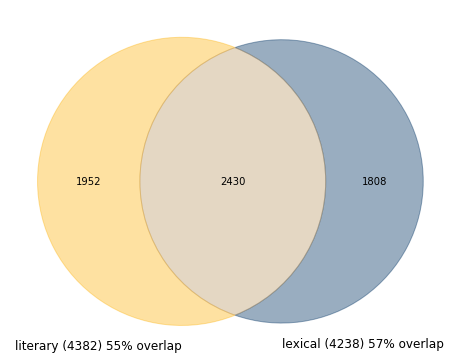

In [13]:
plot_venn(lit_words_s, lexical_words_s, 'venn_1.png')

### 3.1.2 Second Approach: Multiple Word Expressions

Instead of looking at individual words (or lexemes), we may also look at lexical *entries* and their presence (or absence) in literary texts. The list of domestic animals, for instance, includes the entry `udu diŋir-e gu₇-a`('sheep eaten by a god'), lemmatized as `udu[sheep]n diŋir[god]n gu[eat]v/t`. Unsurprisingly, all these very common lemmas appear in the literary corpus, and thus in our previous analysis this item results in three hits. But does the expression as a whole ever appear in the literary corpus? 

In order to perform the comparison on the lexical entry level we first need to represent our data (lexical and literary) as lines, rather than as individual words. Lines in lexical texts will become our multiple word expressions. Lines in literary texts will serve as boundaries, since we do not expect our multiple word expressions to continue from one line to the next.

We will use the Multiple Word Expressions (MWE) Tokenizer from the Natural Language Toolkit (`nltk`) to identify and mark the lexical expressions in the literary corpus. Essentially MWETokenizer processes a text that is already tokenized, combining tokens that belong together in a Multiple Word Expression according to a list of such expressions provided by the user. The corpus to be tokenized with MWETokenizer is expected to be a list of lists, where each lower level list represents a sentence. The data format for the Multiple Word Expressions is a list of tuples, where each tuple represents a sequence of words that belong together. In order to use MWETokenizer for our purposes we thus need to transform the [epsd2/literary](http://oracc.org/epsd2/literary) data into a list of lists and the lexical data into a list of tuples.

#### 3.1.2.1 Line by Line

The dataframe `lex_words` that was produced in section 3.1.0.3 contains the lemmatizations of all Old Babylonian lexical texts in a word-by-word (or rather lemma-by-lemma) arrangement. In order to work with lexical *entries* we need to reconstruct lines. That is, we collect the words (lemmas) that belong to the same line of the same lexical text. The dataframe `lex_words` includes the fields `id_text` and `id_line` that allow us to do so. 

| id_text | id_line | lemma|
|:-------|:------|:------|
| dcclt/Q000001 |	1 | udu\[sheep\]n |
| dcclt/Q000001|	1 | niga\[fattened\]v/i|
| dcclt/Q000001|	2 |	udu\[sheep\]n|
| dcclt/Q000001|	2 |	niga\[fattened\]v/i|
| dcclt/Q000001|	2 |	sag\[rare\]v/i|

We need to change the above representation into two entries (representing two lines in a lexical text) like this:

| id_text | id_line | lemma|
|:-------|:------|:------|
| dcclt/Q000001 |	1 | udu\[sheep\]n niga\[fattened\]v/i |
| dcclt/Q000001|	2 | udu\[sheep\]n niga\[fattened\]v/i, sag\[rare\]v/i |

In order to do this we use the Pandas functions `groupby()` and `agg()` (for aggregate). For a brief explanation of these functions see the [Basic ORACC Parser](../2_1_Data_Acquisition_ORACC/2_1_2_basic_ORACC-JSON_parser.ipynb) (in particular section 3.3: Group by TextID). The `to_pickle` function from the `pandas` package saves the resulting DataFrame for use in the next notebook.

In [14]:
lex_lines = lex_words.groupby([lex_words['id_text'], lex_words['id_line']]).agg({
        'lemma': ' '.join
    }).reset_index()
lex_lines.to_pickle('output/lexlines.p')

In [15]:
lex_lines[:10]

,id_text,id_line,lemma
0,dcclt/P117394,2,kid[mat]n
1,dcclt/P117394,3,kid[mat]n andul[shade]n
2,dcclt/P117394,4,kid[mat]n antadul[cloak]n
3,dcclt/P117395,2,ŋeše[key]n
4,dcclt/P117395,3,pakud[~tree]n
5,dcclt/P117395,4,raba[clamp]n
6,dcclt/P117396,2,hašhur[apple]n
7,dcclt/P117396,3,hašhur[apple]n baza[dwarf]n
8,dcclt/P117396,4,hašhur[apple]n mari[1]sn
9,dcclt/P117397,2,laqipu[1]dn


Now we do the same for the `lit_words` dataframe, reconstructing lines in literary compositions. 

In [16]:
lit_lines = lit_words.groupby([lit_words['id_text'], lit_words['id_line']]).agg({
        'lemma': ' '.join
    }).reset_index()

In [17]:
lit_lines[1200:1210]

,id_text,id_line,lemma
1200,epsd2/literary/P346106,17,x[na]na x[na]na
1201,epsd2/literary/P346107,3,innin[lady]n ki[place]n aŋ[measure]v/t dumuzid...
1202,epsd2/literary/P346107,4,x[na]na x[na]na gur[lift]v/t ki[place]n aŋ[mea...
1203,epsd2/literary/P346107,5,a[water]n x-x[na]na zid[right]v/i šag[heart]n ...
1204,epsd2/literary/P346107,6,nin[sister]n namnin[ladyship]n utud[bear]v/t
1205,epsd2/literary/P346107,7,tur[stall]n i[oil]n gara[cream]n x[na]na si[fi...
1206,epsd2/literary/P346107,8,amaš[sheepfold]n i[oil]n x[na]na mu-un-da-an-b...
1207,epsd2/literary/P346107,9,aneden[steppe]n x[na]na x[na]na x-a-ŋu₁₀[na]na...
1208,epsd2/literary/P346107,10,a[water]n kisikil[woman]n x[na]na x[na]na me[b...
1209,epsd2/literary/P346107,11,dumu[child]n banda[junior]v/i x[na]na me[be]v/i


#### 3.1.2.2 Extract lexical entries 
Each row in the resulting DataFrame `lex_lines` now consists of a text ID (`id_text`), a line number (`id_line`), and a sequenbce of lemmas representing a lexical *entry* (e.g. `udu[sheep] diŋir[god] gu[eat])`). We extract the `lemma` column, remove duplicate lexical entries with the `set()` function and use a list comprehension to turn each lexical entry (sequence of lemmas) into a tuple. This creates a list of tuples, which is the data format we need for the MWEtokenizer. 

Any lexical line that contains an unlemmatized word (characterized by "na" as Guide Word) is useless for the comparison and is deleted from the list. 

In [18]:
lex = set(lex_lines["lemma"])
lex = [tuple(item.split()) for item in lex if not '[na]na' in item]
lex[-30:]

[('bareda[strap]n',),
 ('mi[cvne]n', 'zid[right]v/i', 'dug[speak]v/t'),
 ('argibil[structure]n',),
 ('lu[person]n',
  'šu[hand]n',
  'zig[rise]v/i',
  'kešed[bind]v/t',
  'dug[speak]v/t'),
 ('zarbilum[1]sn',),
 ('gi[reed]n', 'dug[good]v/i'),
 ('azalulu[multitude]n',),
 ('a[water]n', 'su[red]v/i'),
 ('ašag[field]n', 'mar[shovel]n'),
 ('ŋeš[tree]n', 'sukud[height]n'),
 ('sugu[need]n',),
 ('šurina-numunkušene[oven-of-the-widows]cn',),
 ('hašhur[apple]n', 'ah[dry]v/i'),
 ('saʾadnim[disease]n',),
 ('kuš[skin]n', 'urmah[lion]n'),
 ('ibsi[square]n',),
 ('hulum[fish-net?]n',),
 ('pešgigua[rodent]n',),
 ('anene[they]ip', 'dirig[exceed]v/i'),
 ('guza[chair]n', 'šagkal[tree]n'),
 ('ašag[field]n', 'dud[mound]n', 'uzud[goat]n'),
 ('inim[word]n', 'zid[right]v/i'),
 ('lu[person]n', 'id[river]n', 'bal[dig]v/t'),
 ('ašag[field]n', 'dud[mound]n', 'urgir[dog]n'),
 ('masab[basket]n', 'ninda[bread]n'),
 ('eden[plain]n', 'tum[suitable]v/i'),
 ('naŋasigaz[mortar]n',),
 ('na[stone]n', 'eš[three]nu', 'giŋ[unit

#### 3.1.2.3 Mark lexical entries in literary texts
The list `lex` now contains all uniquely lemmatized entries in the Old Babylonian lexical corpus as edited in [DCCLT](http://oracc.org/dcclt). This is the vocabulary that we wish to find in the literary corpus as edited in [epsd2/literary](http://oracc.org/epsd2/literary).

In order to do so we must re-tokenize the literary corpus, using the Multiple Word Expressions Tokenizer from `nltk`. This tokenizer is initialized with a list of tuples, where each tuple represents a Multiple Word Expression. By default, the words that constitute a MWE are connected by underscores.

For this purpose we will first remove from `lex` the single-word entries (tuples with length 1). The resulting list is called `lex_mwe`. Now the tokenizer is inititalized with `lex_mwe` as its sole argument.

In [19]:
lex_mwe = [item for item in lex if len(item) > 1]
tokenizer = MWETokenizer(lex_mwe)

To illustrate how the MWETokenizer works we may try it on a single line of text, line 148 of the composition [Iddin-Dagan A](http://etcsl.orinst.ox.ac.uk/cgi-bin/etcsl.cgi?text=c.2.5.3.1&amp;display=Crit&amp;charenc=gcirc):

> 148. {udu}a-lum udu zulumḫi udu niga ŋiš mu-ni-ib-tag-ge
>
> "They sacrifice *aslum* sheep, long-haired sheep, and fattened sheep for her."

In the `lemma` column of the `etcsl` DataFrame the line is represented as
> [aslum[sheep]n, udu[sheep]n, zulumhi[sheep]n, udu[sheep]n, niga[fattened]v/i, ŋeš[tree]n, tag[touch]v/t]

We can run this list of lemmas through the tokenizer to see what happens.

In [20]:
lemm_line = ["aslum[sheep]n", "udu[sheep]n", "zulumhi[sheep]n", "udu[sheep]n", "niga[fattened]v/i", "ŋeš[tree]n", "tag[touch]v/t"]
tokenizer.tokenize(lemm_line)

['aslum[sheep]n',
 'udu[sheep]n_zulumhi[sheep]n',
 'udu[sheep]n_niga[fattened]v/i',
 'ŋeš[tree]n_tag[touch]v/t']

The tokenizer thus found three Multiple Word Expressions in this single line and connected the lemmas of the MWEs by underscores. The line also illustrates a limitation of this approach. The [epsd2/literary](http://oracc.org/epsd2/literary) edition of [Iddin-Dagan A](http://oracc.org/epsd2/literary/Q000447) represents the first word of line 148 as {udu}a-lum, taking "udu" (sheep) as a determinative (or semantic classifier). The edition of the list of animals in [OB Ura 3](http://oracc.org/dcclt/Q000001) in [DCCLT](http://oracc.org/dcclt), however, treats this same sign sequence as a sequence of two words: udu a-lum, lemmatized as udu\[sheep\]N aslum\[sheep\]N (line 8). Although aslum\[sheep\]N will result in a match, it will seem that the combination udu\[sheep\]N aslum\[sheep\]N does not appear in the literary corpus. Matches are only found if the words are represented in exactly the same way, and small inconsistencies in lemmatization may result in false negatives.

We can now apply the MWE tokenizer on the entire data set, by re-tokenizing each list of lemmas in the `lemma` column of the `lit_lines` DataFrame. The function `tokenize_sents()` (for "tokenize sentences") can be used to tokenize a list of lists where each second-order list represents a sentence (or, in our case, a line) in one go. The result of this function is again a list of lists; it contains the same tokens, but now Multiple Word Expressions are connected by underscores.

We extract the `lemma` from the `lit_lines` DataFrame and split each entry into a list - producing a list of list that can be fed as input to the MWETokenizer. The output is again a list of list - each line is represented by a list of lemmas. These lists are joined, so that each line is now again represented by a sequence of lemmas in a single string. This data is added as a new column (`lemma_mwe` to the DataFrame `lit_lines`

The `lemma_mwe` column of the `lit_lines` dataframe will now represent the [epsd2/literary](http:oracc.org/epsd2/literary) data in a line-by-line presentation of lemmatizations, with underscores connecting lemmas if a corresponding sequence of lemmas exists as an Old Babylonian lexical entry. This version of the DataFrame `lit_lines` is pickled for use in the next notebook.

In [21]:
lemma_list = [lemma.split() for lemma in lit_lines["lemma"]]
lemma_mwe = tokenizer.tokenize_sents(lemma_list)
lit_lines["lemma_mwe"] = [' '.join(line) for line in lemma_mwe]
lit_lines.to_pickle('output/litlines.p')

Now join all the tuples in the list `lex` with underscores, so that the multiple-word entries in the lexical corpus are represented in the same way as they are in the literary corpus. Thus the entry **udu diŋir-e gu₇-a** (sheep eaten by a god) has gone through the following transformations:
* lemmatization: udu\[sheep\]n diŋir\[god\]n gu\[eat\]V/t
* tuple (lex):   (udu\[sheep\]n, diŋir\[god\]n, gu\[eat\]V/t)
* MWE (lex_vocab): udu\[sheep\]n_diŋir\[god\]n_gu\[eat\]V/t

In [22]:
lex_vocab = ["_".join(entry) for entry in lex]
lex_vocab.sort()

We can now extract the column `lemma_mwe` from the `lit_lines` DataFrame in order to get a full list of all lemmas and Multiple Word Expressions in the entire [epsd2/literary](http:oracc.org/epsd2/literary) data set. In order to do so we will first join all entries in `lemma_mwe` (joining all literary lines into one big sequence of entries) and then split the result by blank space. That will create a list of all vocabulary items - with MWEs joined by underscores.

We will turn this list into a set (to remove duplicate lemmas and duplicate Multiple Word Expressions) and remove all the non-lemmatized words from the [epsd2/literary](http:oracc.org/epsd2/literary) data set with a single set comprehension. That is the set that we can compare with the set of lemmas and MWEs from the lexical corpus.

In [23]:
lit_words2 = ' '.join(lit_lines['lemma_mwe']).split()
lit_words_s2 = {lemma for lemma in lit_words2 if not '[na]na' in lemma}
lexical_words_s2 = set(lex_vocab)

We can now reuse the function `plot_venn()` that was created above.

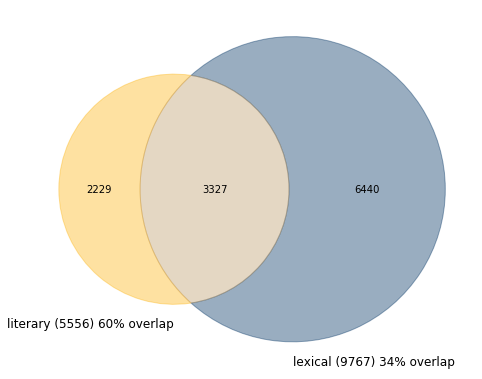

In [24]:
plot_venn(lit_words_s2, lexical_words_s2, 'venn_2.png')

### 3.1.3 Add them Up
By creating the union of the two sets (the set with individual words and the set with the lexical entries) we get the most complete comparison of the two corpora. Here `gud[oxen]N_an[heaven]N`, `gud[oxen]N` and `an[heaven]N` are all counted as separate vocabulary items, whether or not `gud` and `an` actually appear as separate entries in the lexical corpus.

The full lexical vocabulary is written to a file for use in the next notebook.

In [25]:
lit_words_s3 = lit_words_s | lit_words_s2
lexical_words_s3 = lexical_words_s | lexical_words_s2
with open('output/lex_vocab.txt', 'w', encoding = 'utf8') as w:
    w.write('\n'.join(lexical_words_s3))

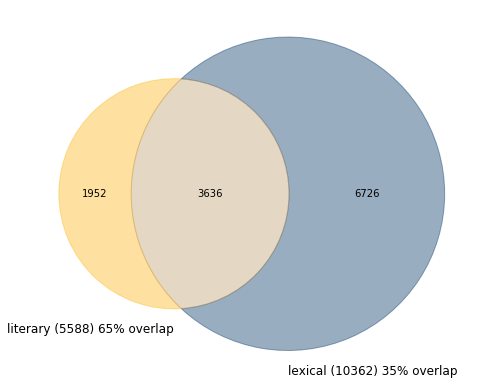

In [26]:
plot_venn(lit_words_s3, lexical_words_s3, 'venn_3.png')

#### 3.1.3.1 Discussion
Whereas the change from individual *words* to *lexical expressions* made a big difference in the plot, adding the two up changes the picture only slightly. Many words (lemmas) are part of lexical entries, but are also lexical entries in and of themselves. These individual words are already included in the set of lexical entries and are taken into account in the previous plot. Nevertheless, there are several hundreds of words added on the lexical side - these are lexemes that *only* appear in multiple-word lexical entries and are not attested in the lexical corpus as separate words. 

On the literary side the number of additional entries is much smaller (counted in the tens, rather than in the hundreds). These are words that appear *only* in fixed expressions (connected by underscore), but not as separate words. We can see which words those are by by subtracting the set `lit_words_s2` from `lit_words_s3`.

In [27]:
lit_words_s3 - lit_words_s2

{'ašrinna[object]n',
 'ašša[perfect]aj',
 'babbardili[~stone]n',
 'bur[grass]n',
 'burgia[offering]n',
 'du[hold]v/t',
 'du₁₀.ud[prayer]n',
 'ebir[vessel-stand]n',
 'giʾiziʾešta[~bread]n',
 'gub[bathe]v/i',
 'hub[cvve]v/t',
 'huldim[rotten]aj',
 'kašu[~plow]n',
 'kiŋ[pointed]v/i',
 'ligidba[plant]n',
 'manzila[foot]n',
 'maʾu[barge]n',
 'mud[rabid]aj',
 'nir[trust]n',
 'niŋkalaga[strong]aj',
 'sa.ku[arm]n',
 'sar[shave]v/t',
 'saŋa[priest]n',
 'tam[cvve]v/t',
 'tuhul[hip]n',
 'tutu[cvve]v/t',
 'ugudili[scalp]n',
 'uzudirig[mushroom]n',
 'zaga[part-of-the-face]n',
 'zana[doll]n',
 'zidsig[flour]n',
 'še[cone]n'}

The word `ašrinna[object]n`, for instance, appears only a few times in the current literary corpus, in one of the Eduba dialogues and in proverbs. 

In [28]:
lit_lines[lit_lines.lemma_mwe.str.contains('ašrinna')]

,id_text,id_line,lemma,lemma_mwe
30771,epsd2/literary/Q000621,42,lulu[man]n kid[mat]n ašrinna[object]n dab[seiz...,lulu[man]n kid[mat]n_ašrinna[object]n dab[seiz...
38567,epsd2/literary/Q000767,18,nimsahara[fly]n kid[mat]n ašrinna[object]n sag...,nimsahara[fly]n kid[mat]n_ašrinna[object]n sag...
41598,epsd2/literary/Q000800,39,nimsahara[fly]n kid[mat]n ašrinna[object]n sig...,nimsahara[fly]n kid[mat]n_ašrinna[object]n sig...


In each case the word is preceded by `kid[mat]n` and this word sequence is also found in [Old Babylonian Nippur Ura 2](http://oracc.org/dcclt/Q000040), line 20. As a result, the lemma sequence `kid[mat]n_ašrinna[object]n` was treated as a unit, a Multiple Word Expression, and the separate word `ašrinna[object]n` was not found in `lit_words_s2`.